In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Load the dataset
file_path = 'ML_LAD2.xlsx'  # Replace with your file path
data = pd.read_excel(file_path,sheet_name='Sheet1')

# Define features and target
X = data.drop(columns=['viable_LAD'])
y = data['viable_LAD']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)


In [3]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(criterion='entropy'),
    'Neural Network': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(solver='lbfgs',penalty='l2',max_iter=2000),
    'SVM': SVC(kernel='linear',probability=True),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.001),
    'Decision Tree': DecisionTreeClassifier()
    
}
# Cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)

In [4]:
X_res

array([[-1.32900794, -1.30613732, -1.17407467, ...,  1.84026128,
        -0.55562791,  1.42484625],
       [ 0.84718084, -0.61719727, -1.76295729, ..., -0.41117882,
        -0.49684935, -0.11756341],
       [-0.44769664, -0.76110919, -1.41655575, ...,  1.5614685 ,
        -0.14723144,  0.24967698],
       ...,
       [-0.17445537, -0.03799703,  1.08540172, ...,  0.28214088,
        -0.84618161, -1.46184157],
       [-0.15064651,  0.34574885,  0.80024252, ..., -0.77340421,
         0.42382299, -0.90763749],
       [-0.83619853, -0.12426648, -0.11219388, ...,  0.30824671,
        -0.10934323, -0.34165665]])

In [5]:

# Initialize results dictionary
results = {
    'Model': [],
    'AUC': [],
    'Accuracy': [],
    'Balanced Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1 Score': []
}


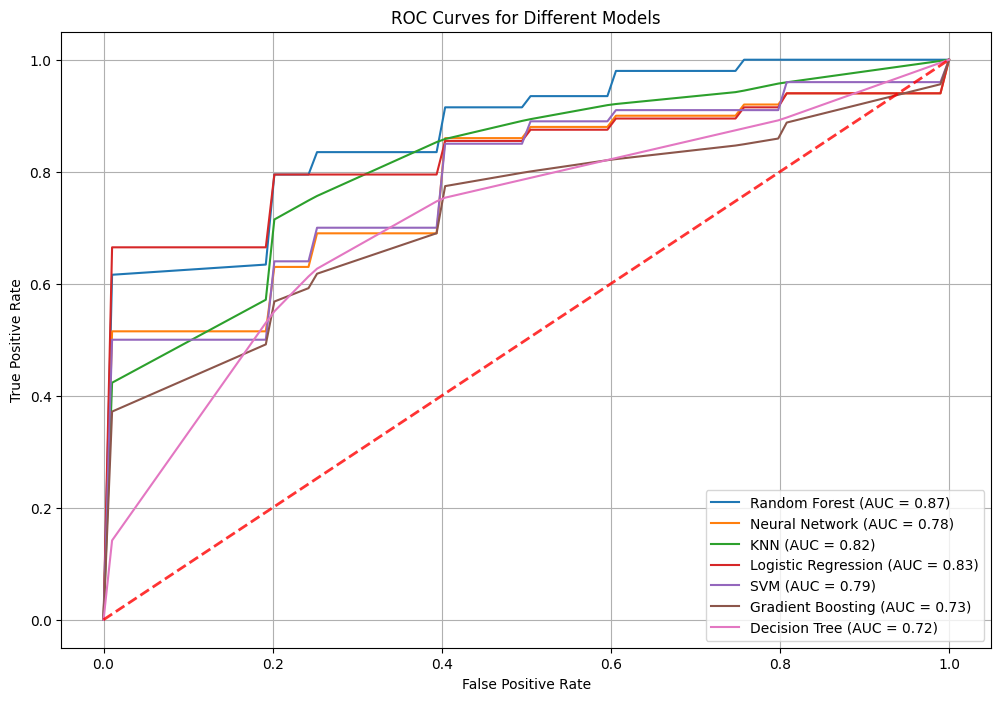

                 Model     AUC  Accuracy  Balanced Accuracy  Recall  \
0        Random Forest  0.8720  0.744444             0.7500   0.750   
1       Neural Network  0.7810  0.744444             0.7425   0.720   
2                  KNN  0.8180  0.746667             0.7525   0.645   
3  Logistic Regression  0.8330  0.776667             0.7725   0.740   
4                  SVM  0.7850  0.723333             0.7200   0.695   
5    Gradient Boosting  0.7255  0.700000             0.7050   0.615   
6        Decision Tree  0.7175  0.711111             0.7175   0.725   

   Precision  F1 Score  
0   0.783095  0.741746  
1   0.785000  0.737626  
2   0.838095  0.702222  
3   0.825000  0.768795  
4   0.766429  0.702778  
5   0.821429  0.654841  
6   0.734762  0.693687  


In [6]:
# Evaluate models and plot ROC curves
plt.figure(figsize=(12, 8))
for name, model in models.items():
    aucs, accuracies, bal_accuracies, recalls, precisions, f1s = [], [], [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_index, test_index in skf.split(X_res, y_res):
        X_train, X_test = X_res[train_index], X_res[test_index]
        y_train, y_test = y_res[train_index], y_res[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        aucs.append(roc_auc_score(y_test, y_prob))
        accuracies.append(accuracy_score(y_test, y_pred))
        bal_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    #std_auc = np.std(aucs)
    #plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f})')

    results['Model'].append(name)
    results['AUC'].append(mean_auc)
    results['Accuracy'].append(np.mean(accuracies))
    results['Balanced Accuracy'].append(np.mean(bal_accuracies))
    results['Recall'].append(np.mean(recalls))
    results['Precision'].append(np.mean(precisions))
    results['F1 Score'].append(np.mean(f1s))

# Plot random chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid()

# Display the plot
plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

In [7]:
# Save DataFrame to Excel
evalution = 'evalution metrics.xlsx'  # Output file name
results_df.to_excel(evalution, index=False)

In [46]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectKBest, f_classif

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'ML_LAD2.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Define features and target
X = data.drop(columns=['viable_LAD'])
y = data['viable_LAD']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='linear',probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
}

# Initialize dictionaries to store feature importance scores
feature_importances = {
    
    'Logistic Regression': [],
    'SVM': [],
    'Gradient Boosting': [],
    'Decision Tree': [],
    'Random Forest': [],
    'KNN': [],
    'Neural Network' :[],
}

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Feature selection and averaging feature importance scores
for name, model in models.items():
    for train_index, test_index in skf.split(X_res, y_res):
        X_train, X_test = X_res[train_index], X_res[test_index]
        y_train, y_test = y_res[train_index], y_res[test_index]
        if name == 'Random Forest' or name == 'Decision Tree' or name =='Gradient Boosting' :
            # Fit and use feature_importances_ attribute
            model.fit(X_train, y_train)
            feature_importances[name].append(model.feature_importances_)
        elif name == 'SVM':
            # SVM doesn't have a direct feature_importances_ attribute, we can use coef_
            model.fit(X_train, y_train)  # Fit SVM model
            feature_importances[name].append(np.abs(model.coef_.flatten()))

        elif name == 'Logistic Regression':
            # Use L1-based feature selection
            selector = SelectFromModel(estimator=model, threshold=-np.inf, max_features=5)
            selector.fit(X_train, y_train)  # Fit the selector
            feature_importances[name].append(selector.estimator_.coef_.flatten())

        elif name == 'KNN' or name == 'Neural Network':
            # Use SelectKBest with ANOVA F-value
            selector = SelectKBest(score_func=f_classif, k=5).fit(X_train, y_train)
            feature_importances[name].append(selector.scores_)
    
# Convert feature importances to numpy arrays
for name in feature_importances:
    feature_importances[name] = np.array(feature_importances[name])

# Calculate average feature importance across folds
average_importances = {name: np.mean(importances, axis=0) for name, importances in feature_importances.items()}

# Print top 5 features based on average importance scores with values
print("Top 5 Features based on Average Importance Scores:")
for name, importances in average_importances.items():
    top_indices = np.argsort(importances)[::-1][:5]
    top_features = X.columns[top_indices]
    top_importance_values = importances[top_indices]
    for feat, imp in zip(top_features, top_importance_values):
        print(f"{name}: {feat} - {imp:.4f}")


Top 5 Features based on Average Importance Scores:
Logistic Regression: T2_global - 1.5225
Logistic Regression: SRS7 - 0.7902
Logistic Regression: T2_1 - 0.7617
Logistic Regression: SRS1 - 0.6539
Logistic Regression: SRS14 - 0.4333
SVM: T2_global - 1.4449
SVM: T2_13 - 1.1685
SVM: SRS7 - 0.9079
SVM: SCS7 - 0.7848
SVM: T2_14 - 0.6636
Gradient Boosting: T2_14 - 0.1874
Gradient Boosting: T2_13 - 0.1629
Gradient Boosting: T2_global - 0.1124
Gradient Boosting: SRS1 - 0.0711
Gradient Boosting: SCS7 - 0.0633
Decision Tree: T2_13 - 0.1810
Decision Tree: T2_14 - 0.1633
Decision Tree: T2_global - 0.1288
Decision Tree: SRS1 - 0.0750
Decision Tree: SCS7 - 0.0660
Random Forest: T2_13 - 0.0795
Random Forest: T2_14 - 0.0714
Random Forest: SCS7 - 0.0444
Random Forest: SCS8 - 0.0394
Random Forest: T2_7 - 0.0391
KNN: T2_13 - 21.3497
KNN: SRS7 - 17.5793
KNN: SRS1 - 12.8922
KNN: SCS13 - 12.6818
KNN: T2_14 - 12.0723
Neural Network: T2_13 - 21.3497
Neural Network: SRS7 - 17.5793
Neural Network: SRS1 - 12.892

In [9]:

# Cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)


In [10]:
# Collect all features
all_features = X.columns


# Feature selection and feature importance scores
for name, model in models.items():
    model_importances = []
    for train_index, test_index in skf.split(X_res, y_res):
        X_train, X_test = X_res[train_index], X_res[test_index]
        y_train, y_test = y_res[train_index], y_res[test_index]
        
        if name == 'Logistic Regression':
            # Use L1-based feature selection
            selector = SelectFromModel(estimator=model, threshold=-np.inf, max_features=5)
            selector.fit(X_train, y_train)  # Fit the selector
            model_importances.append(selector.estimator_.coef_.flatten())
        elif name == 'SVM':
            # SVM doesn't have a direct feature_importances_ attribute, we can use coef_
            model.fit(X_train, y_train)  # Fit SVM model
            model_importances.append(np.abs(model.coef_.flatten()))
        elif name == 'Gradient Boosting' or name == 'Decision Tree' or name == 'Random Forest':
            # Fit and use feature_importances_ attribute
            model.fit(X_train, y_train)
            model_importances.append(model.feature_importances_)
        elif name == 'KNN' or name == 'Neural Network':
            # Use SelectKBest with ANOVA F-value
            selector = SelectKBest(score_func=f_classif, k=5).fit(X_train, y_train)
            model_importances.append(selector.scores_)
    
    # Convert model_importances to numpy array
    model_importances = np.array(model_importances)
    
    # Store all feature importances for the model
    feature_importances[name] = model_importances

# Prepare a list to hold all rows of the DataFrame
rows = []

# Collect all feature importances into a structured DataFrame
for feat_idx, feat_name in enumerate(all_features):
    row = {'Feature': feat_name}
    for model_name, importances in feature_importances.items():
        importance_values = []
        for fold_idx, importance_scores in enumerate(importances):
            importance_value = importance_scores[fold_idx][feat_idx] if isinstance(importance_scores[0], np.ndarray) else importance_scores[feat_idx]
            importance_values.append(importance_value)
        row[model_name] = np.mean(importance_values)  # Taking the mean importance across folds
    rows.append(row)

# Create DataFrame from rows
df_importances = pd.DataFrame(rows)

# Save DataFrame to Excel
output_file = 'feature_importances_models.xlsx'  # Output file name
df_importances.to_excel(output_file, index=False)

print(f"Feature importances saved to {output_file}")

Feature importances saved to feature_importances_models.xlsx


In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = 'feature_importances_models.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Separate feature names and data
features = data.iloc[:, 0]  # Assuming first column contains feature names
X = data.iloc[:, 1:]  # Assuming remaining columns are the data

# Apply MinMaxScaler to the data (excluding the first column)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Create DataFrame with normalized data
normalized_data = pd.DataFrame(X_scaled, columns=X.columns)

# Insert the first column of feature names
normalized_data.insert(0, 'Feature', features)

# Save DataFrame to Excel
output_normalized_file = 'normalized_data.xlsx'  # Output file name
normalized_data.to_excel(output_normalized_file, index=False)

print(f"Normalized data saved to {output_normalized_file}")


Normalized data saved to normalized_data.xlsx
